In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import poisson
from typing import Tuple

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (8, 4)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.facecolor'] = 'white'

#### 4.4. Value iteration

> We implement exercise 4.9: **Gambler's problem**

---

The state represents the gambler's capital. The set of states possible states is:
\begin{align}
    s \in \{ 1, 2, \dots , 99  \}
\end{align}

The actions are the amount of capital that is put at stake at a given turn. The set of possible actions depends on the state and is:
\begin{align}
    a \in \{ 0, 1, \dots \min(s, 100-s) \}
\end{align}

The next state $s'$ is determined by $s, a$ and the outcome of a coin flip:
\begin{align}
s' = 
\begin{cases}
s + a \quad \text{if coin is } H \\
s - a \quad \text{if coin is } T
\end{cases}
\end{align}

Since we are given the probabilities of the coin coming up heads and tail, we know that:
\begin{align}
s' = 
\begin{cases}
s + a \quad \text{with probability }  p_h \\
s - a \quad \text{with probability}  (1 - p_h)
\end{cases}
\end{align}

Finally, the gambler receives a reward of +1 when it reaches the goal state of $100$ and zero otherwise.

Now we can implement value iteration to learn the probability of winning from each state.

In [33]:
'''
Initialize
'''
MAX_SWEEPS = 50
PROB_HEADS = 0.4
GOAL = 99
THETA = 1e-15

# We have 99 (capital) + 1 (goal state) possible states  
states_set = np.arange(GOAL)
values = np.zeros(GOAL+1)
policy = np.zeros(GOAL)

# We know that the value of s = 100 is +1
values[GOAL] = 1
value_sweeps = []
num_sweeps = 0
delta_sweeps = np.zeros(MAX_SWEEPS)

In [38]:
## Policy evaluation
while num_sweeps < MAX_SWEEPS:
    delta = 0
    value_sweeps.append(values.copy())
    
    print(f'Policy evaluation | Sweep: {num_sweeps}')    
    # Loop over states
    for state in states_set[1:]:

        # Create action set based on state
        action_set = np.arange(min(state, GOAL - state) + 1)

        # v <-- V(s)
        old_value = values[state]
        
        # V(s) <-- max(expected value from state)
        values[state] = np.max([
            PROB_HEADS * values[state + action] + (1 - PROB_HEADS) * values[state - action] for action in action_set
        ])
        # Update delta
        delta = max(delta, abs(old_value - values[state]))

    delta_sweeps[num_sweeps] = delta
    num_sweeps += 1

    if delta < THETA:
        # Keep track of values over sweeps
        value_sweeps.append(values.copy())
        break
   
print(f'Policy improvement')
## Policy improvement
for state in states_set[1:]:
    action_set = np.arange(min(state, GOAL - state) + 1)

    # Compute the expected value for each action from that state
    expected_returns = np.round([
        PROB_HEADS * values[state + action] + (1 - PROB_HEADS) * values[state - action] for action in action_set
    ], 5)

    # pi(s) <-- arg max_a (expected value for state)
    # Output a greedy deterministic policy (exclude the zero action)
    policy[state] = action_set[np.argmax(np.array(expected_returns[1:]))]


Policy evaluation | Sweep: 27
Policy evaluation | Sweep: 28
Policy evaluation | Sweep: 29
Policy evaluation | Sweep: 30
Policy evaluation | Sweep: 31
Policy evaluation | Sweep: 32
Policy evaluation | Sweep: 33
Policy evaluation | Sweep: 34
Policy evaluation | Sweep: 35
Policy evaluation | Sweep: 36
Policy evaluation | Sweep: 37
Policy evaluation | Sweep: 38
Policy evaluation | Sweep: 39
Policy evaluation | Sweep: 40
Policy evaluation | Sweep: 41
Policy evaluation | Sweep: 42
Policy evaluation | Sweep: 43
Policy evaluation | Sweep: 44
Policy evaluation | Sweep: 45
Policy evaluation | Sweep: 46
Policy evaluation | Sweep: 47
Policy evaluation | Sweep: 48
Policy improvement


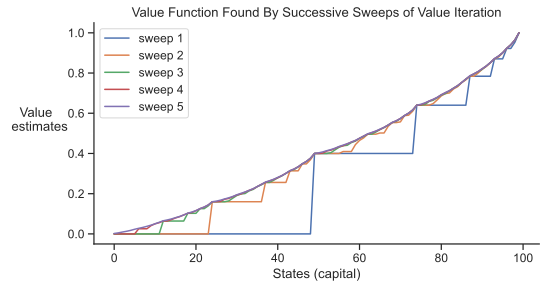

In [39]:
plt.title('Value Function Found By Successive Sweeps of Value Iteration')
for sweep_idx, values in enumerate(value_sweeps[1:6]): plt.plot(values[1:], label=f'sweep {sweep_idx+1}')
plt.xlabel('States (capital)')
plt.ylabel('Value \n estimates', rotation=0, labelpad=30)
plt.legend()
sns.despine()

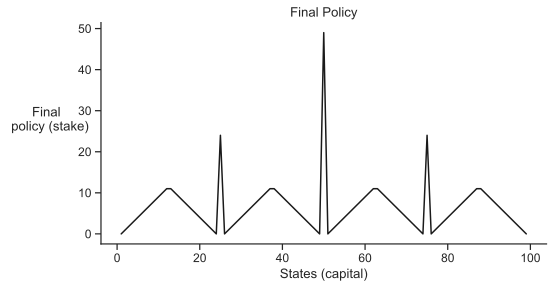

In [40]:
plt.title('Final Policy')
plt.plot(states_set[1:], policy[1:], '-k',)
plt.xlabel('States (capital)')
plt.ylabel('Final \n policy (stake)', rotation=0, labelpad=30)
sns.despine()

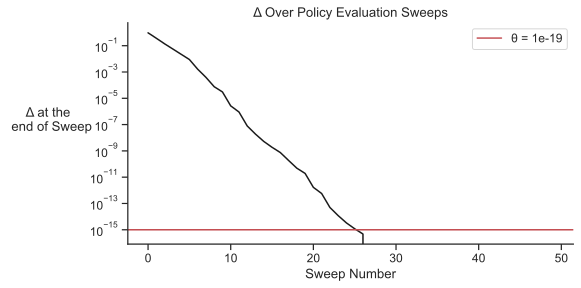

In [37]:
plt.title('Δ Over Policy Evaluation Sweeps')
plt.plot(range(MAX_SWEEPS), delta_sweeps, '-k',)
plt.axhline(y=THETA, color='r', linestyle='-', label='θ = 1e-19')
plt.yscale('log')
plt.xlabel('Sweep Number')
plt.ylabel('Δ at the \n end of Sweep', rotation=0, labelpad=40)
plt.legend()
sns.despine()

### Observations

- **Value function**. We can see that the first sweep (i.e. doing policy evaluation for the first time) gives a value function that is a kind of step-wise increasing function. As the capital increases (state), the value estimate of this state increases as well. Note that the mapping from states $\to$ values becomes more smooth as we do more and more policy evaluations. After 6 
  - _Why?_ This can be explained by the fact that we use averages (see $V(s')$) to update the value estimates, and those average get better over time. Each time we perform a sweep, the value of every state in our array is updated.
\begin{align}
  V(s) \leftarrow \max_a \sum_{s', r} p(s', r \mid s, a) [\quad \underbrace{r}_{\text{reward obtained NOW}} \quad + \quad  \underbrace{\gamma V(s')}_{\text{Discounted estimate of the next state}} \quad ]
\end{align}
 
- **Q: Are your results stable as $\theta \to 0$?** Based on the learned value function and the above figure, which shows the max delta at the end of our sweeps vs. the sweep number, I am fairly confident that the results are stable. However, I do have to round the expected value for each action before taking the arg max in the policy improvement step to get the final policy function that is shown in the book. When I don't round to the 5th decimal, the final policy has a few more spikes than the figure in the book, which suggests that there may be some numerical instabilities. As noted in the book however, the policy here is not unique and there are a whole family of policies in this setting. 

- **Policy**. The policy is a mapping from states to actions. What is interesting here is that in some states, the action value (i.e. money to put at stake) is much higher than for others (e.g. compare 25 to 20). This shape depends on the probability of getting heads, $p_h$. I think the shape is due to the size of the action set, which is a function of $s$. The action set is:
\begin{align}
    a \in \{ 0, 1, \dots \min(s, 100-s) \}
\end{align}

This is how $\mathcal{A}$, the action set, changes over $s$:
  - when $s = 1, \mathcal{A} = \{ 0, 1 \}$
  - when $s = 2, \mathcal{A} = \{ 0, 1, 2 \}$
  - this pattern continues (expanding set) until $s=50$
  - when $s = 50, \mathcal{A} = \{ 0, 1, 2, \dots, 50 \}$
  - when $s = 51, \mathcal{A} = \{ 0, 1, 2, \dots, 49 \}$
  - when $s = 52, \mathcal{A} = \{ 0, 1, 2, \dots, 48 \}$
  - all the way to... $s = 99, \mathcal{A} = \{ 0, 1 \}$
So, some states simply have more iterations (and thus total value) than others. Also, the value only increases when state + action reaches the goal state, which is 1 or, in later iterations, when the states are not zero anymore.